**Names:**

PD_28_Khushi Tiwari    1032211126

PD_29_Gauransh Jain    1032211193

PD_25_Anuj Langade     1032211013

PD_61_Drashti Panchal  1032221209


# Topic and Introduction

---



---

`Topic:` Pneumonia Detection through X-ray images

`Introduction:` In this project we are predicting whether pneumonia exists in a given image. We do so by predicting bounding boxes around areas of the lung. Samples without bounding boxes are negative and contain no definitive evidence of pneumonia. Samples with bounding boxes indicate evidence of pneumonia.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Setup

---



---

`from pathlib import Path:` Imports the Path class for file system operations, allowing easy handling of file paths.

`import pydicom:` A library to work with DICOM files, commonly used for medical images.

`import numpy as np:` Imports NumPy for numerical computations and array operations.

`import pandas as pd:` Imports Pandas for handling data structures like DataFrames.

`import cv2:` OpenCV library for image processing tasks.

`import matplotlib.pyplot as plt:` Used for plotting images and visualizing data.

`import matplotlib.patches as patches:` Adds shapes (e.g., rectangles) to plots.

`from tqdm.notebook import tqdm:` Progress bar to show the progress of loops.

In [ ]:
!pip install pydicom scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.1 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import pydicom
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'pylibjpeg'
ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, i

# Load and Preprocess the CSV Data

---



---

#### Load and Parse the Labels

In [ ]:
# Load labels (CSV)
labels_df = pd.read_csv('/content/drive/My Drive/DL Miniproject/stage_2_train_labels.csv')

# Since it's binary classification, we'll assign a binary label (1: pneumonia, 0: no pneumonia)
labels_df['target'] = labels_df['Target'].apply(lambda x: 1 if x > 0 else 0)

# Drop duplicate patientIds to avoid redundant data entries
labels_df = labels_df.drop_duplicates(subset=['patientId'])

# Data Loading Function for DICOM Images

---



---



In [ ]:
# Load the CSV with patient IDs and labels
labels_df = pd.read_csv('/content/drive/My Drive/DL Miniproject/stage_2_train_labels.csv')
labels_df['target'] = labels_df['Target'].apply(lambda x: 1 if x > 0 else 0)
labels_df = labels_df.drop_duplicates(subset=['patientId'])

# Generator to load and preprocess DICOM images
def dicom_data_generator(image_dir, df, batch_size=32, img_size=(128, 128)):
    while True:
        for start in range(0, len(df), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df))
            df_batch = df[start:end]
            for _, row in df_batch.iterrows():
                file_path = os.path.join(image_dir, row['patientId'] + '.dcm')
                dicom = pydicom.read_file(file_path)
                img = dicom.pixel_array
                img_resized = cv2.resize(img, img_size)
                img_resized = np.stack((img_resized,)*3, axis=-1)  # Convert to 3-channel
                img_resized = img_resized / 255.0  # Normalize
                x_batch.append(img_resized)
                y_batch.append(row['target'])
            yield np.array(x_batch), np.array(y_batch)

# Split the dataset
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['target'], random_state=42)

# Create train and validation generators
train_gen = dicom_data_generator('/content/drive/My Drive/DL Miniproject/stage_2_train_images', train_df, batch_size=32)
val_gen = dicom_data_generator('/content/drive/My Drive/DL Miniproject/stage_2_train_images', val_df, batch_size=32)

# Data Augmentation and Generators

---



---



In [ ]:
!pip install pydicom
# Ensure that the pydicom module is installed

import pydicom
# Import the pydicom module correctly

# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# No augmentation for validation, only rescaling
val_datagen = ImageDataGenerator()

# Create generators for augmented training and validation
def dicom_data_generator_with_aug(image_dir, df, datagen, batch_size=32, img_size=(128, 128), augment=False):
    while True:  # Infinite loop to continuously generate data
        for start in range(0, len(df), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df))
            df_batch = df.iloc[start:end]  # Use iloc for proper row indexing
            for _, row in df_batch.iterrows():
                file_path = os.path.join(image_dir, row['patientId'] + '.dcm')
                dicom = pydicom.dcmread(file_path) # Use dcmread instead of read_file
                img = dicom.pixel_array
                img_resized = cv2.resize(img, img_size)
                img_resized = np.stack((img_resized,)*3, axis=-1)  # Convert to 3-channel
                img_resized = img_resized / 255.0  # Normalize
                x_batch.append(img_resized)
                y_batch.append(row['target'])

            # Check if the batch is not empty before yielding
            if len(x_batch) > 0 and len(y_batch) > 0:
                x_batch = np.array(x_batch)
                y_batch = np.array(y_batch)

                # Apply data augmentation if enabled
                if augment:
                    x_batch, y_batch = next(datagen.flow(x_batch, y_batch, batch_size=batch_size))

                yield x_batch, y_batch

# Augmented train generator
train_gen = dicom_data_generator_with_aug('/content/drive/My Drive/DL Miniproject/stage_2_train_images',
                                          train_df, train_datagen, batch_size=32, augment=True)

# Validation generator without augmentation
val_gen = dicom_data_generator_with_aug('/content/drive/My Drive/DL Miniproject/stage_2_train_images',
                                        val_df, val_datagen, batch_size=32, augment=False)

# VGG19 Model Definition
---



---

### Adjust the input shape in VGG19 and other model layers:

In [ ]:
# Load VGG19 without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Train the Model (with callbacks)
---



---

### We used EarlyStopping to avoid overfitting and ModelCheckpoint to save the best model.


In [ ]:
import tensorflow as tf

# Enable mixed precision for faster training
policy = tf.keras.mixed_precision.Policy('mixed_float16') # Removed experimental namespace
tf.keras.mixed_precision.set_global_policy(policy) # Use set_global_policy instead of set_policy

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Increase the batch size for faster training
batch_size = 64  # Adjust based on memory

# Adjust the steps_per_epoch to process fewer batches
steps_per_epoch = len(train_df) // (4 * batch_size)  # Only process 1/4th of the data per epoch for faster execution
validation_steps = len(val_df) // (4 * batch_size)

history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=validation_steps,
                    epochs=2,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 1036s 13s/step - accuracy: 0.7646 - loss: 0.5393 - val_accuracy: 0.7891 - val_loss: 0.4782
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 1001s 12s/step - accuracy: 0.7708 - loss: 0.5208 - val_accuracy: 0.8031 - val_loss: 0.4435
Restoring model weights from the end of the best epoch: 2.


# Fine-Tuning (Unfreezing Layers)
---



---

### After initial training, we unfreezed some of the layers of the base model to fine-tune and recompile:


In [ ]:
# Unfreeze fewer layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:20]:  # Freeze more layers (only fine-tune top few layers)
    layer.trainable = False

# Recompile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model for fine-tuning with fewer steps
history_fine = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // (4 * batch_size),
    validation_data=val_gen,
    validation_steps=len(val_df) // (4 * batch_size),
    epochs=2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 1039s 13s/step - accuracy: 0.7896 - loss: 0.4793 - val_accuracy: 0.7719 - val_loss: 0.4593
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 1026s 12s/step - accuracy: 0.7836 - loss: 0.4741 - val_accuracy: 0.7734 - val_loss: 0.4628
Restoring model weights from the end of the best epoch: 1.


# Evaluate the Model
---



---

### Evaluate the model performance on the validation set:

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_gen, steps=len(val_df) // 32)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

166/166 ━━━━━━━━━━━━━━━━━━━━ 1571s 9s/step - accuracy: 0.7700 - loss: 0.4566
Validation Loss: 0.4593212902545929
Validation Accuracy: 0.7749292850494385


# Visualizing the results
---



---

### Visualizing the model's predictions:

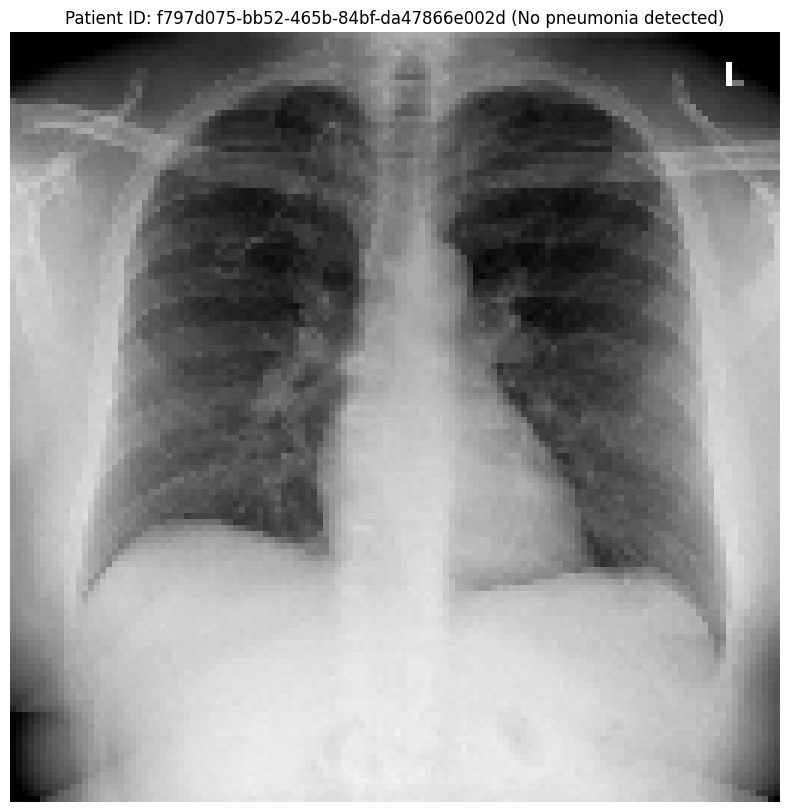

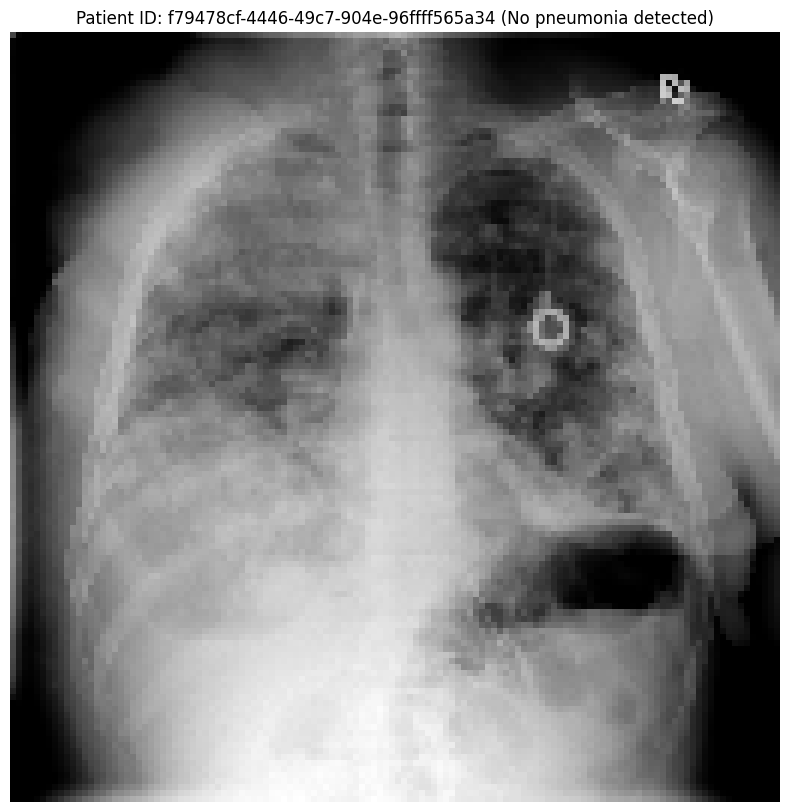

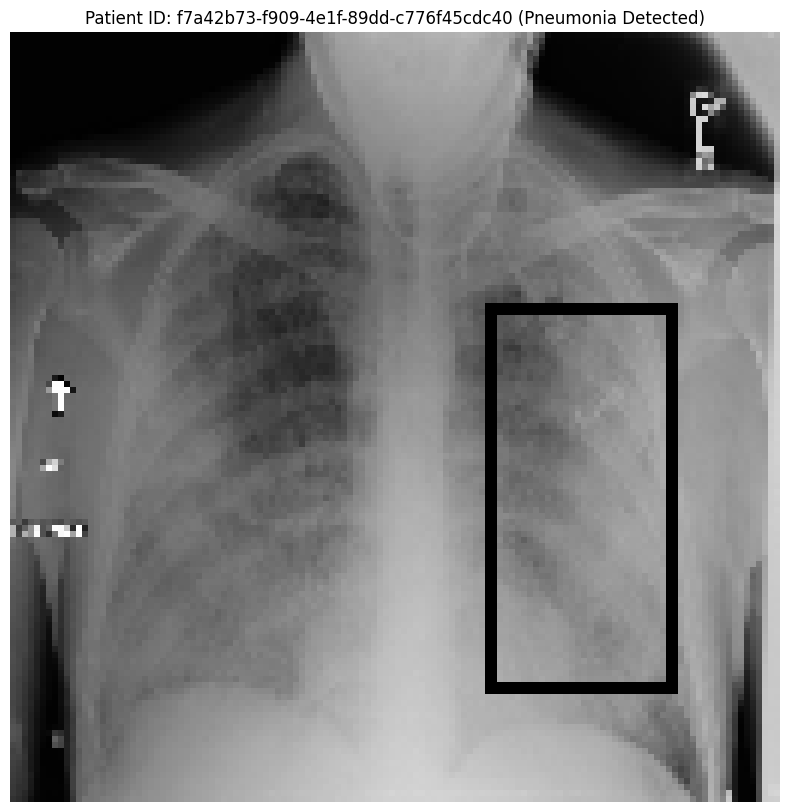

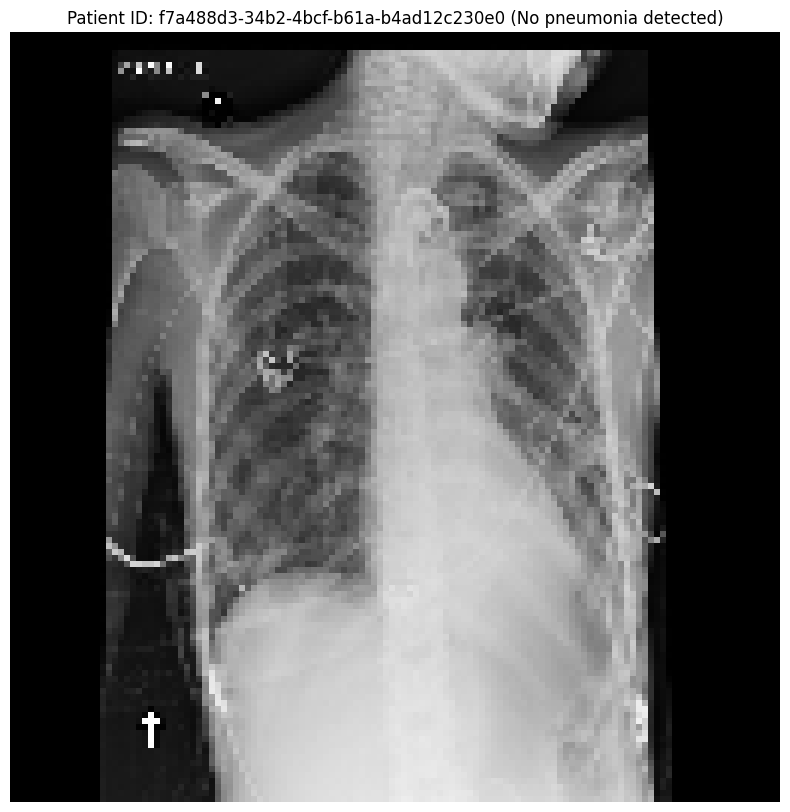

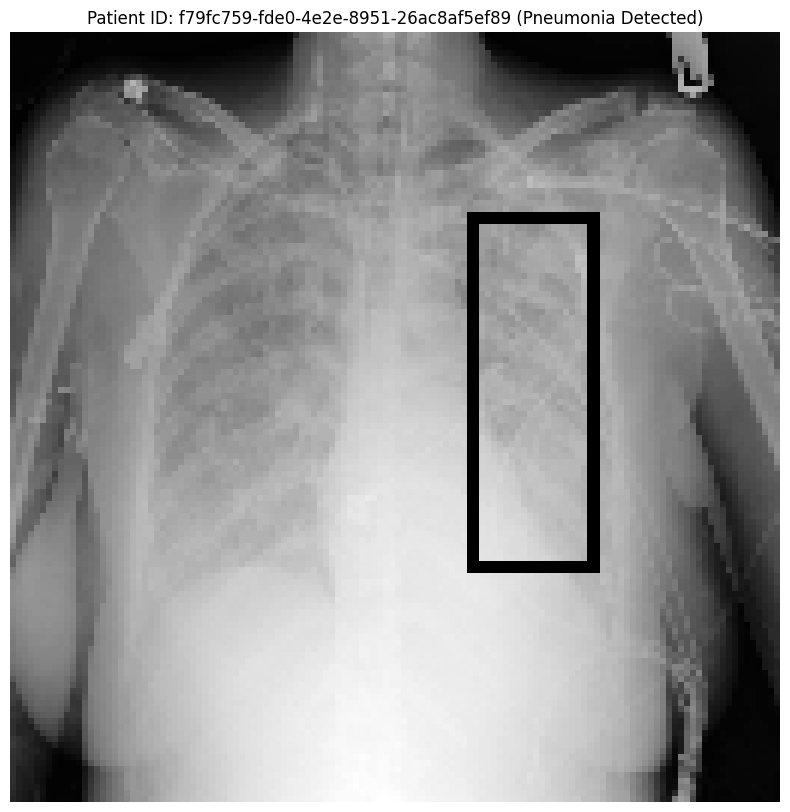

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from PIL import Image, ImageDraw
import cv2

# File paths
csv_path = '/content/drive/My Drive/DL Miniproject/stage_2_train_labels.csv'
image_dir = '/content/drive/My Drive/DL Miniproject/stage_2_train_images'

# Read CSV file
df = pd.read_csv(csv_path)

# Helper function to read DICOM image
def read_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    return Image.fromarray(np.uint8(image))

# Helper function to draw bounding box
def draw_bounding_box(image, x, y, width, height):
    draw = ImageDraw.Draw(image)

    # Ensure coordinates are within the image bounds
    x = max(0, x)
    y = max(0, y)
    width = min(width, image.width - x)
    height = min(height, image.height - y)

    draw.rectangle([x, y, x + width, y + height], outline="black", width=2)  # Black bounding box
    return image

# Helper function to resize bounding box
def resize_bounding_box(x, y, width, height, original_size, new_size):
    old_width, old_height = original_size
    new_width, new_height = new_size
    scale_x = new_width / old_width
    scale_y = new_height / old_height
    x = int(x * scale_x)
    y = int(y * scale_y)
    width = int(width * scale_x)
    height = int(height * scale_y)
    return x, y, width, height

# Resize image to new size
def resize_image(image, size=(128, 128)):
    return cv2.resize(np.array(image), size)

# Get the first 10 image files
image_files = os.listdir(image_dir)[:5]

# Process images
for img_file in image_files:
    patient_id = img_file.split('.')[0]
    img_path = os.path.join(image_dir, img_file)

    # Read DICOM image
    img = read_dicom_image(img_path)

    # Resize image
    original_size = img.size
    img_resized = resize_image(img, (128, 128))
    img_resized_pil = Image.fromarray(img_resized)

    # Find matching row in CSV
    row = df[df['patientId'] == patient_id]

    # If there's a match and it's a positive case (Target == 1)
    if not row.empty and row['Target'].values[0] == 1:
        if not row[['x', 'y', 'width', 'height']].isnull().values.any():
            x, y, width, height = row[['x', 'y', 'width', 'height']].values[0]
            # Adjust bounding box for resized image
            x, y, width, height = resize_bounding_box(x, y, width, height, original_size, (128, 128))
            img_with_box = draw_bounding_box(img_resized_pil, x, y, width, height)

            # Display the image with bounding box
            plt.figure(figsize=(10, 10))
            plt.imshow(img_with_box, cmap='gray')
            plt.title(f"Patient ID: {patient_id} (Pneumonia Detected)")
            plt.axis('off')
            plt.show()
    else:
        # Display the image without bounding box
        plt.figure(figsize=(10, 10))
        plt.imshow(img_resized_pil, cmap='gray')
        plt.title(f"Patient ID: {patient_id} (No pneumonia detected)")
        plt.axis('off')
        plt.show()